# Under the hood

* What is a graph-based machine-learned potential energy surface (ML-PES)?
* How does ``graph-pes`` work under the hood to construct and learn an ML-PES from data?

The following document attempts to answer these two questions while relying on as little background knowledge as possible.


## Atomic structures

Potential energy surfaces (PESs) are functions that act on atomic structures to return an energy. What do we mean by an "atomic structure" here?

In its most general form, an atomic structure is defined as a collection of atoms, where each atom has an associated:
- position in space, $\vec{r}_i$ (i.e. a 3D vector)
- type, $z_i$ (i.e., an integer equal to the atomic number)

It is worth noting that we are treating these atoms [classically](https://en.wikipedia.org/wiki/Classical_mechanics), _i.e._ as point particles with a well-defined position in space.

> For the mathematically inclined, we can formally express a structure $S$ containing $N$ atoms as:
> $$
> S = \left\{ \vec{r}_i, z_i \right\}_{i=1}^N ; \quad \vec{r}_i \in \mathbb{R}^3, \; z_i \in \mathbb{Z}
> $$
> _i.e._ as a [set](https://en.wikipedia.org/wiki/Set_(mathematics)) of $N$ particles, where each particle has an associated position and type.



When implementing an atomic structure in code, it is convenient to use the ordered collections $R$ and $Z$, such that the $i$-th atom in the structure has position $\vec{r}_i = R[i]$ and atomic number $z_i = Z[i]$:

In [16]:
from typing import TypedDict

import torch


class Structure(TypedDict):
    Z: torch.Tensor  # shape: (N,), dtype: int64
    R: torch.Tensor  # shape: (N, 3), dtype: float

For instance, the [ground-state structure](https://en.wikipedia.org/wiki/Ground_state) of a water molecule is approximately:

In [17]:
water_structure = {
    "Z": torch.tensor([8, 1, 1]),  # (O, H, H)
    "R": torch.tensor(
        [
            [0.0000, 0.0000, 0.0000],
            [0.9584, 0.0000, 0.0000],
            [-0.2401, 0.9278, 0.0000],
        ]
    ),
}
{k: t.shape for k, t in water_structure.items()}

{'Z': torch.Size([3]), 'R': torch.Size([3, 3])}

## Potential energy surfaces (PESs)

As we stated above, a [potential energy surface](https://en.wikipedia.org/wiki/Potential_energy_surface) (PES) is any [function](https://en.wikipedia.org/wiki/Function_(mathematics)) that takes an atomic structure as an input, and returns a scalar, real-valued number (the "potential" energy) as an output:
$$
\text{structure} \; \xrightarrow{\text{PES}} \; \text{energy}
$$
where, for a structure containing $N$ atoms:

- $Z \in \mathbb{Z}^N$
- $R \in \mathbb{R}^{N \times 3}$
- $E \in \mathbb{R}$

In [18]:
from typing import Callable

PES = Callable[
    [Structure],
    torch.Tensor, # shape: (1,), dtype: float
]

Any function that conforms to this definition can be considered as a potential energy surface.

The **true** PES is the one that exists in the real world.
Assuming that quantum mechanics is "correct", we can in principle calculate the true energy for any atomic structure, given sufficient computational resources.
In practice, this is infeasible for all but the simplest systems.
We therefore often rely on approximate PESs, including empirical approximations (very fast, not very true to nature) and _ab initio_ approximations (very slow, somewhat true to nature).

[Machine-learned PESs](https://en.wikipedia.org/wiki/Machine-learned_interatomic_potential) (ML-PESs) approximate _ab initio_ PESs by training on datasets of atomic structure together with labels generated by _ab initio_ methods.


## A basic ML-PES

As ML-PES architects, we are free to choose any functional form we want.
Let's do something extremely simple by concatenating $Z$ and $R$ together, and passing them through a neural network (see below for why this is probably a very bad idea)

In [19]:
from typing import Sequence


class LabelledStructure(Structure):
    energy: torch.Tensor  # shape: (1,), dtype: float


class ThreeAtomPES(torch.nn.Module):
    """A simple PES that acts on structures composed of 3 atoms."""
    
    def __init__(self, internal_dim: int = 128):
        super().__init__()
        # for each of the 3 atoms, there are 4 degrees of freedom: Z, Rx, Ry, Rz
        input_dim = 4 * 3
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, internal_dim),
            torch.nn.CELU(),
            torch.nn.Linear(internal_dim, internal_dim),
            torch.nn.CELU(),
            torch.nn.Linear(internal_dim, 1),
        )

    def featurize(self, structure: Structure) -> torch.Tensor:
        """Convert a structure into a feature vector of shape (12,)"""
        return torch.cat([structure["Z"].float(), structure["R"].reshape(-1)])

    def forward(self, structure: Structure) -> torch.Tensor:
        """Evaluate the PES at a given structure."""
        features = self.featurize(structure)  # (12,)
        return self.net(features)  # (1,)

    @torch.no_grad()
    def pre_fit(self, dataset: Sequence[LabelledStructure]) -> None:
        """Pre-fit the model to a dataset before training."""
        energies = torch.stack([s["energy"] for s in dataset])
        self.net[-1].bias.data = torch.mean(energies).unsqueeze(0)


torch.manual_seed(0)  # for reproducibility
pes_model = ThreeAtomPES()
pes_model(water_structure)

tensor([0.3207], grad_fn=<ViewBackward0>)

There we have it, a potential energy surface that takes in the locations and identities of 3 atoms, and returns an energy of the corresponding structure.

By passing different structures through our PES model, we can get a sense of what this 12 dimensional (3 atoms, each with 3 coordinates and an atomic number) function looks like. Below, we scan over one of the O-H "bond lengths" (more on that later) moving that H atom while keeping everything else fixed to create a 1D slice through the PES:

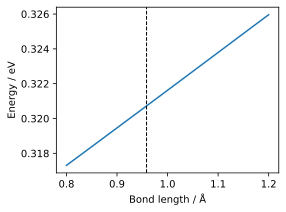

In [20]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'


def generate_water_structure(r1=0.9584, r2=0.9584, theta=104.51) -> Structure:
    """
    Generate a water structure with given bond length and angle (in degrees).
    """
    theta = torch.deg2rad(torch.tensor(theta))
    x = r2 * torch.cos(theta)
    y = r2 * torch.sin(theta)
    return {
        "Z": torch.tensor([8, 1, 1]).long(),
        "R": torch.tensor([[0.0, 0.0, 0.0], [r1, 0.0, 0.0], [x, y, 0.0]]),
    }


def r1_scan_plot(model):
    """Plot the energy of the O-H bond stretch for a given model"""
    rs = torch.linspace(0.8, 1.2, 100)
    with torch.no_grad():
        energies = [
            # get the energy of a water structure for each value of r1
            model(generate_water_structure(r1=r.item()))
            for r in rs
        ]

    plt.figure(figsize=(4, 3))
    plt.plot(rs, energies)
    plt.axvline(0.9584, c="k", ls="--", lw=1)
    plt.xlabel("Bond length / Å")
    plt.ylabel("Energy / eV")


r1_scan_plot(pes_model)

This PES is clearly "wrong" in the sense that it is not yet predicting a minimum in energy at the ground-state bond length (depicted by the dashed line above).

This is where machine learning comes in!
We use a dataset of structures and corresponding energy labels from some other source (usually an accurate quantum mechanical calculation) to update the "parameters" of our model.
During this training process, we hope that our model can learn to predict the energy of a structure with high accuracy.

Let's start by loading in a dataset of water structures I have created earlier and labelled with the [GFN2-xTB](https://pubs.acs.org/doi/10.1021/acs.jctc.8b01176) method.

In [21]:
dataset: list[LabelledStructure] = torch.load("water-data.pt")
len(dataset)

500

In [22]:
dataset[0]

{'Z': tensor([8, 1, 1]),
 'R': tensor([[ 0.0000,  0.0000,  0.0000],
         [ 1.0049,  0.0000,  0.0000],
         [-0.7734,  0.5429,  0.0000]]),
 'energy': tensor([-13.2658]),
 'forces': tensor([[ 1.3493e+00,  8.6844e-01,  5.4183e-16],
         [-2.5099e+00, -2.2861e+00, -4.6312e-16],
         [ 1.1605e+00,  1.4177e+00, -7.8710e-17]])}

We can see that this dataset contains 500 labelled water structures.

Below, we implement an extremely simple training loop to train our `water_pes` model on this dataset.

In [23]:
# define a training and test set
training_set, test_set = dataset[:400], dataset[400:]

# pre-fit the model
pes_model.pre_fit(training_set)

# perform simple, un-batched training loop
n_epochs = 500
optimiser = torch.optim.Adam(pes_model.parameters(), lr=1e-3)
losses = []
for epoch in range(n_epochs):
    total_loss = 0.0
    for structure in training_set:
        optimiser.zero_grad()
        energy_pred = pes_model(structure)
        loss = torch.nn.functional.l1_loss(energy_pred, structure["energy"])
        loss.backward()
        optimiser.step()
        total_loss += loss.item()

    mean_loss = total_loss / len(training_set)
    losses.append(mean_loss)

    if (epoch + 1) % 25 == 0:
        # gradually decay the learning rate
        for param_group in optimiser.param_groups:
            param_group["lr"] *= 0.9
        print(
            f"Epoch {epoch + 1:>3}/{n_epochs} "
            f"Loss: {mean_loss:.4f}"
        )

pes_model.eval();

Epoch  25/500 Loss: 0.3677
Epoch  50/500 Loss: 0.3400
Epoch  75/500 Loss: 0.3110
Epoch 100/500 Loss: 0.2655
Epoch 125/500 Loss: 0.1873
Epoch 150/500 Loss: 0.1599
Epoch 175/500 Loss: 0.1450
Epoch 200/500 Loss: 0.1352
Epoch 225/500 Loss: 0.1202
Epoch 250/500 Loss: 0.1133
Epoch 275/500 Loss: 0.1004
Epoch 300/500 Loss: 0.0946
Epoch 325/500 Loss: 0.0892
Epoch 350/500 Loss: 0.0851
Epoch 375/500 Loss: 0.0779
Epoch 400/500 Loss: 0.0751
Epoch 425/500 Loss: 0.0771
Epoch 450/500 Loss: 0.0655
Epoch 475/500 Loss: 0.0657
Epoch 500/500 Loss: 0.0624


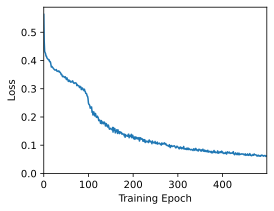

In [24]:
plt.figure(figsize=(4, 3))
plt.plot(losses)
plt.xlabel("Training Epoch")
plt.ylabel("Loss")
plt.ylim(bottom=0)
plt.xlim(0, len(losses)-1);

We could dramatically improve performance by using a batched implementation, shuffling the training data, standardizing the input features, training for longer, and implementing some early stopping, but as a quick proof of concept, this is sufficient.

How well did our model do? Let's start by looking at a parity plot:

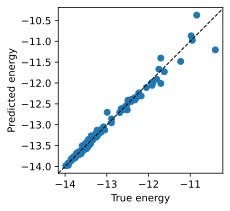

In [25]:
with torch.no_grad():
    predictions = [pes_model(s).item() for s in test_set]
    ground_truth = [s["energy"].item() for s in test_set]

plt.figure(figsize=(3, 3))
plt.scatter(ground_truth, predictions)
e = ground_truth[0]
plt.axline((e, e), slope=1, c="k", ls="--", lw=1)
plt.xlabel("True energy")
plt.ylabel("Predicted energy")
plt.gca().set_aspect("equal");

Our model appears to [generalize](https://en.wikipedia.org/wiki/Generalization_(machine_learning)) reasonably well to unseen data, as the predicted energies are close to the ground-truth values for all structures in the test set.

Our model also reproduces the ground-state bond length of water reasonably well:

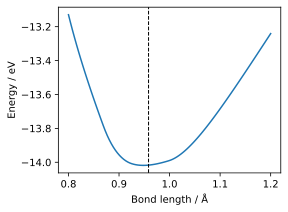

In [26]:
r1_scan_plot(pes_model)

## Extensivity and locality

We have a model that can act on structures composed of 3 atoms, and we have trained it on a dataset of water structures. Where do we go from here?

There are (several) obvious problems with our current model, foremost of which is that we are not capable of acting on structures of arbitrary size:

In [34]:
methane = {
    "Z": torch.tensor([6, 1, 1, 1, 1]).long(),
    "R": torch.tensor(
        [
            [0.0, 0.0, 0.0],
            [0.63, 0.63, 0.63],
            [-0.63, -0.63, 0.63],
            [0.63, -0.63, -0.63],
            [-0.63, 0.63, -0.63],
        ]
    ).float(),
}

try:
    pes_model(methane)
except Exception as e:
    print("Exception:", e)

Exception: mat1 and mat2 shapes cannot be multiplied (1x20 and 12x128)


A stop-gap solution to this problem is to expand the maximum size of structure that our model can act on (say to 200 atoms), and to zero-pad any input structures that are smaller than this maximum size. However, we want our ML-PES models to be able to generalise to [extremely large structures](), and so this approach is not a general solution.

To make progress, the dominant approach is to recognise that:

1. **total potential energy is an extensive property**, and hence can be written as a sum of per-atom contributions:
$$
E = \sum_{i} \varepsilon_i
$$
2. (most) **quantum mechanical interactions are local**, and so each of these per-atom contributions, $\varepsilon_i$, can be approximated as a function of atom $i$'s identity and its local environment, $\zeta_i$:
$$
\varepsilon_i = \varepsilon \left( z_i, \zeta_i \right)
$$
where:
$$
\zeta_i = \left\{ (\vec{r}_{ij}, z_j) \right\}_{j \in \mathcal{N}(i)} 
$$
is the set of all neighbouring atoms, and $\vec{r}_{ij} = \vec{r}_j - \vec{r}_i$ is the vector pointing from atom $i$ to its $j$-th neighbour.

There are various ways to define the set of neighbours $\mathcal{N}(i)$ for each atom $i$, with the most popular being radial-cutoff and k-nearest-neighbours approaches.
The general way to encode the neighbourhood of each atom is to use a [graph](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)) to represent the structure, where each atom is a node, and a directed edge exists between nodes $i$ and $j$ if and only if atom $j$ is in the local neighbourhood of atom $i$.

In [ ]:
class AtomicGraph(TypedDict):
    Z: torch.Tensor  # shape: (N,), dtype: int
    R: torch.Tensor  # shape: (N, 3), dtype: float
    neighbour_list: torch.Tensor  # shape: (Y, 2), dtype: int

## Some problems

We have a model that can act on structures composed of 3 atoms, and we have trained it on a dataset of water structures. Where do we go from here?

There are a few obvious problems with our current approach.
The first of these is that our simple model architecture (that acts directly on the cartesian co-ordinates of the atoms) lacks crucial [invariances](https://en.wikipedia.org/wiki/Invariant_(physics)) that are realistic PES should have. These are:

**Invariance to translation**: moving the entire structure in space in a rigid manner should not change the energy of the structure. Unfortunately, our current architecture does not have this property:

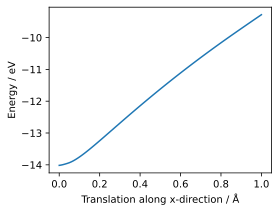

In [27]:
# gradually move the structure along the x direction
vector = torch.tensor([1.0, 0.0, 0.0])
distances = torch.linspace(0, 1, 100)

energies = []
for d in distances:
    structure = generate_water_structure(r1=0.9584, r2=0.9584, theta=104.51)
    structure["R"] += d * vector
    energies.append(pes_model(structure).item())

plt.figure(figsize=(4, 3))
plt.plot(distances, energies)
plt.xlabel("Translation along x-direction / Å")
plt.ylabel("Energy / eV");

**Invariance to rotation**: a rigid rotation of the structure should not change the energy of the structure. Unfortunately, our current architecture does not have this property:

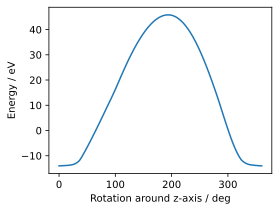

In [28]:
# rotate the structure around the z-axis
angles = torch.linspace(0, 360, 100)

energies = []
for angle in angles:
    angle = torch.deg2rad(angle)
    structure = generate_water_structure(r1=0.9584, r2=0.9584, theta=104.51)
    rotation_matrix = torch.tensor(
        [
            [torch.cos(angle), -torch.sin(angle), 0.0],
            [torch.sin(angle), torch.cos(angle), 0.0],
            [0.0, 0.0, 1.0],
        ]
    )
    structure["R"] = (rotation_matrix @ structure["R"].T).T
    energies.append(pes_model(structure).item())

plt.figure(figsize=(4, 3))
plt.plot(angles, energies)
plt.xlabel("Rotation around z-axis / deg")
plt.ylabel("Energy / eV");

**Invariance to permutation**: as we noted above, structures are _sets_ of atoms: the order of the atoms does not matter, and so permuting the order of $R$ and $Z$ should not change the energy of the structure. Unfortunately, our current architecture does not have this property:

In [29]:
energies = []

for permutation in [
    [0, 1, 2], [0, 2, 1], [1, 0, 2], [1, 2, 0], [2, 0, 1], [2, 1, 0]
]:
    structure = generate_water_structure(r1=0.9584, r2=0.9584, theta=104.51)
    structure["Z"] = structure["Z"][permutation]
    structure["R"] = structure["R"][permutation]
    energies.append(pes_model(structure).item())

energies

[-14.016752243041992,
 31.053260803222656,
 -9.169607162475586,
 -12.495540618896484,
 -10.388723373413086,
 -10.468202590942383]

Alongside these lack of invariances, there is another, more serious, problem: our current architecture cannot handle structures of different sizes:

In [32]:
from ase.build import molecule

methane = molecule("CH4")
methane_structure = {
    "Z": torch.tensor(methane.numbers).long(),
    "R": torch.tensor(methane.positions).float(),
}

try:
    pes_model(methane_structure)
except Exception as e:
    print("Exception:", e)

Exception: mat1 and mat2 shapes cannot be multiplied (1x20 and 12x128)


While data augmentation can help to re-gain approximate model invariance, it cannot help with the problem of different sized structures.

A common solution to these problems is to use use a **graph-based** representation of atomic structure, and to design architectures that can operate on these:


## Atomic Graphs

We start by making two observations: 

- the total energy of a system is an extensive property, and can be written as a sum over contributions from each atom: $E = \sum_i \varepsilon_i$
- quantum mechanical interactions are (very often) **local** in nature, such that these per-atom contributions can be approximated as functions of each atom's local environment

$$
\varepsilon_i = \varepsilon \left( \left\{ (\vec{r}_{ij}, z_j) \right\}_{j \in \mathcal{N}(i)} \right)
$$

where $\mathcal{N}(i)$ is the set of atoms that are considered to be "neighbours" of atom $i$, and $\vec{r}_{ij} = |\vec{r}_i - \vec{r}_j|$ is the distance between atoms $i$ and $j$.

A **graph** representation allows us to incorporate locality into the 



**What about forces?**

Given some PES, the force on an atom within a structure is defined as the negative [gradient](https://en.wikipedia.org/wiki/Gradient) of the PES with respect to the atom's position:
$$
\vec{f}_i = -\nabla_{\vec{r}_i} E(S)
$$

One reason we have been using the `torch` library above is that we can use [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) to get the gradient of the PES, and hence the atomic forces, with just a few extra lines of code:




In [ ]:
structure = test_set[0]
structure["R"].requires_grad = True
E = pes_model(structure)
F = torch.autograd.grad(E, structure["R"])[0]
F

tensor([[ 0.1292, -0.1435,  0.1057],
        [-0.3715,  0.0696,  0.0173],
        [ 1.2186, -1.5182, -0.1605]])

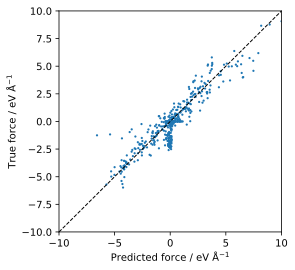

In [37]:
def get_H_forces(model, structure: Structure) -> Float[torch.Tensor, "N 3"]:
    structure["R"].requires_grad = True
    E = model(structure)
    dE_dR = torch.autograd.grad(E, structure["R"])[0]
    return -dE_dR[structure["Z"] == 1]

all_forces = torch.vstack([get_H_forces(pes_model, s) for s in test_set])
gt_forces = torch.vstack([s["forces"][s["Z"] == 1] for s in test_set])

plt.figure(figsize=(4, 4))
plt.scatter(all_forces.flatten(), gt_forces.flatten(), lw=0, s=5)
plt.axline((0, 0), slope=1, c="k", ls="--", lw=1)
plt.xlabel("Predicted force / eV Å$^{-1}$")
plt.ylabel("True force / eV Å$^{-1}$")
plt.xlim(-10, 10)
plt.ylim(-10, 10);